In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/image-sift/Gambar 1.jpeg
/kaggle/input/image-sift/Gambar 2.jpeg


In [2]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

Jumlah keypoints: 1862


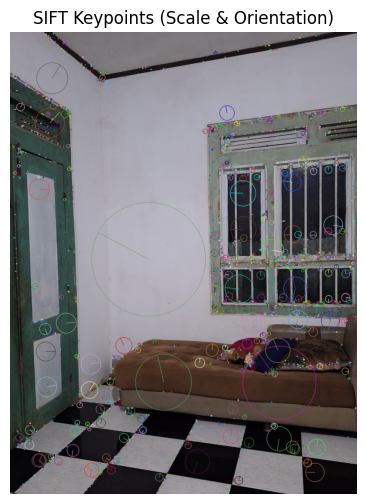

In [3]:

img = cv2.imread('/kaggle/input/image-sift/Gambar 1.jpeg')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(gray, None)

print("Jumlah keypoints:", len(keypoints))

img_kp = cv2.drawKeypoints(
    img_rgb,
    keypoints,
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
)

plt.figure(figsize=(10, 6))
plt.imshow(img_kp)
plt.title("SIFT Keypoints (Scale & Orientation)")
plt.axis('off')
plt.show()

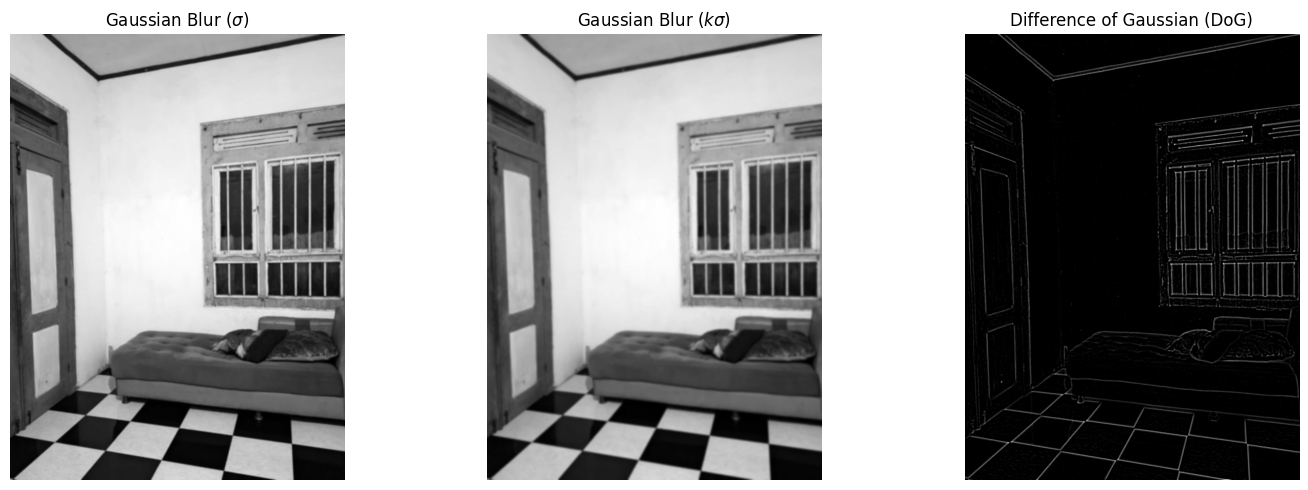

In [4]:

img = cv2.imread('/kaggle/input/image-sift/Gambar 1.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sigma = 1.6       
k = 1.6            
sigma_k = sigma * k

blur_sigma = cv2.GaussianBlur(gray, (0, 0), sigmaX=sigma)

blur_sigma_k = cv2.GaussianBlur(gray, (0, 0), sigmaX=sigma_k)

dog = cv2.subtract(blur_sigma_k, blur_sigma)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(blur_sigma, cmap='gray')
plt.title(r"Gaussian Blur ($\sigma$)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(blur_sigma_k, cmap='gray')
plt.title(r"Gaussian Blur ($k\sigma$)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dog, cmap='gray')
plt.title("Difference of Gaussian (DoG)")
plt.axis('off')

plt.tight_layout()
plt.show()

Keypoints img1: 1862
Keypoints img2: 2344
Good matches: 275


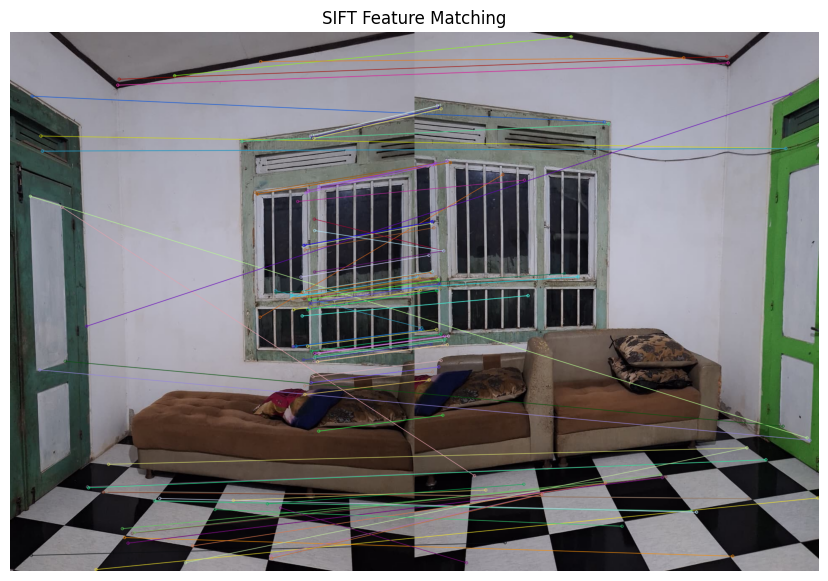

In [5]:
img1 = cv2.imread('/kaggle/input/image-sift/Gambar 1.jpeg')
img2 = cv2.imread('/kaggle/input/image-sift/Gambar 2.jpeg')

# Convert BGR to RGB (for matplotlib)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print("Keypoints img1:", len(kp1))
print("Keypoints img2:", len(kp2))

bf = cv2.BFMatcher(cv2.NORM_L2)

matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
ratio = 0.7
for m, n in matches:
    if m.distance < ratio * n.distance:
        good_matches.append(m)

print("Good matches:", len(good_matches))

matched_img = cv2.drawMatches(
    img1_rgb, kp1,
    img2_rgb, kp2,
    good_matches[:100], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(14, 7))
plt.imshow(matched_img)
plt.axis('off')
plt.title("SIFT Feature Matching")
plt.show()

Keypoints img1: 1862
Keypoints img2: 2344
Good matches: 337


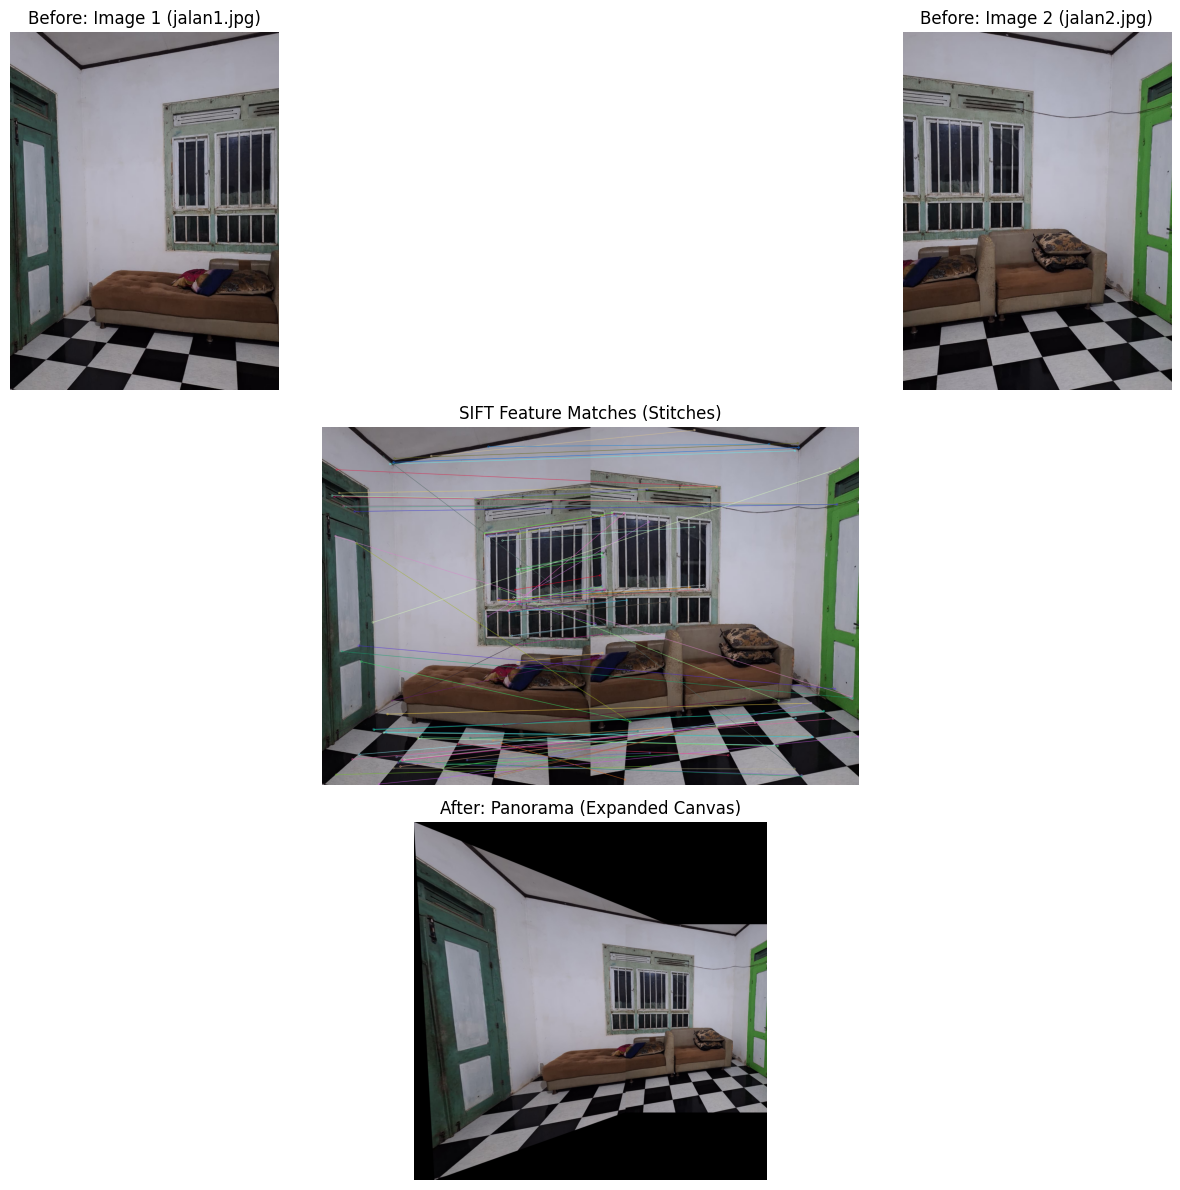

In [6]:
img1 = cv2.imread('/kaggle/input/image-sift/Gambar 1.jpeg')
img2 = cv2.imread('/kaggle/input/image-sift/Gambar 2.jpeg')

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print("Keypoints img1:", len(kp1))
print("Keypoints img2:", len(kp2))

bf = cv2.BFMatcher(cv2.NORM_L2)
matches = bf.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print("Good matches:", len(good_matches))

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

h1, w1 = img1.shape[:2]
h2, w2 = img2.shape[:2]

corners_img1 = np.float32([
    [0, 0],
    [w1, 0],
    [w1, h1],
    [0, h1]
]).reshape(-1, 1, 2)

corners_img2 = np.float32([
    [0, 0],
    [w2, 0],
    [w2, h2],
    [0, h2]
]).reshape(-1, 1, 2)

warped_corners_img1 = cv2.perspectiveTransform(corners_img1, H)

all_corners = np.concatenate((warped_corners_img1, corners_img2), axis=0)

x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
x_max, y_max = np.int32(all_corners.max(axis=0).ravel())

panorama_width  = x_max - x_min
panorama_height = y_max - y_min

translation = np.array([
    [1, 0, -x_min],
    [0, 1, -y_min],
    [0, 0, 1]
])

panorama = cv2.warpPerspective(
    img1,
    translation @ H,
    (panorama_width, panorama_height)
)

panorama[-y_min:h2 - y_min, -x_min:w2 - x_min] = img2

panorama_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)

matches_vis = cv2.drawMatches(
    img1_rgb, kp1,
    img2_rgb, kp2,
    good_matches[:100],   # batasi agar tidak terlalu padat
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(18, 12))

plt.subplot(3, 2, 1)
plt.imshow(img1_rgb)
plt.title("Before: Image 1 (jalan1.jpg)")
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(img2_rgb)
plt.title("Before: Image 2 (jalan2.jpg)")
plt.axis('off')


plt.subplot(3, 2, (3, 4))
plt.imshow(matches_vis)
plt.title("SIFT Feature Matches (Stitches)")
plt.axis('off')

plt.subplot(3, 2, (5, 6))
plt.imshow(panorama_rgb)
plt.title("After: Panorama (Expanded Canvas)")
plt.axis('off')

plt.tight_layout()
plt.show()

(np.float64(-0.5), np.float64(2395.5), np.float64(2433.5), np.float64(-0.5))

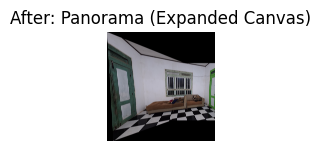

In [7]:
plt.subplot(3, 2, (5, 6))
plt.imshow(panorama_rgb)
plt.title("After: Panorama (Expanded Canvas)")
plt.axis('off')